# Estimating CATEs for survival analysis

[Survival analysis](https://en.wikipedia.org/wiki/Survival_analysis), which primarily deals with time-to-event data, often manifests itself in crucial areas such as healthcare (e.g., patient survival times), social sciences, and engineering.
In the following example, we will demonstrate the use of our `metalearners` library in survival analysis to estimate {term}`CATEs<Conditional Average Treatment Effect (CATE)>`.

## Loading the data

First we will load the data. For this example we will use a dataset from [Rossi et al. - Money, Work and Crime (1980)](https://gwern.net/doc/sociology/1980-rossi-moneyworkandcrime.pdf). The data describes 432 convicts who were released from Maryland state prisons in the 1970s and who were observed for one year after release. Half the released convicts were assigned at random to an experimental treatment in which they were given financial aid; half did not receive aid.

In [1]:
import pandas as pd
from git_root import git_root

rossi = pd.read_csv(git_root("data/rossi.csv"))
rossi.head()

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


Next we will create the ``X``, ``y`` and ``w`` variables necessary for training our MetaLearner. In this dataset we have 6 feature columns but we will also add a column ``"censored"`` to ``X`` which indicates if the observation was censored (meaning that the event did not occur before a time limit -- one year in this case).

In [2]:
feature_columns = ["age", "race", "wexp", "mar", "paro", "prio"]
X = rossi[feature_columns].copy(deep=True)
X["censored"] = 1 - rossi["arrest"]
for c in ["race", "wexp", "mar", "paro", "censored"]:
    X[c] = X[c].astype("category")

y = rossi["week"]
w = rossi["fin"]

## Creating the base models

Some survival models face two primary challenges:

* **Time to event prediction:** Certain models, particularly those relying on the [Cox Proportional Hazards Model](https://en.wikipedia.org/wiki/Proportional_hazards_model), may not directly provide the time to event prediction. Instead, they yield hazard proportions; however, the desired output is the more useful and direct measure of time to the event.

* **Censoring Support:** Survival analysis involves dealing with censored data, where the outcome variable ``y`` may not always be a singular real number for each observation and could be an interval instead.


To address these issues, we need to construct a model to act as the nuisance model. Here's how we can address the associated problems:

* **Time to event prediction:** The principle to remember is that this nuisance model, when invoking the ``predict`` method, must return a time to event prediction for each observation. In this case, we will employ [``xgboost`` with Accelerated Failure Time](https://xgboost.readthedocs.io/en/stable/tutorials/aft_survival_analysis.html), since its output is inherently the time to event. However, other models may necessitate integration over the survival function or require other transformations to get expected survival time predictions.

* **Censoring Support:** For handling this issue, we keep ``y`` as is. If the event was observed, the value represents when it occurred, and if not observed, it is the censoring time. We then augment the ``X`` dataset with an extra column (which won't be passed to the model), labeled ``"censored"``, indicating whether the observation was censored or not. This column aids in constructing the upper and lower bounds for the output label from the model.


We suggest leveraging the base classes from ``sklearn`` to ensure that some essential methods needed for the MetaLearner are pre-defined and can be utilized effectively.

In [3]:
import xgboost as xgb
from sklearn.base import BaseEstimator, RegressorMixin, check_is_fitted
import numpy as np


class SurvivalModel(RegressorMixin, BaseEstimator):
    def __init__(self, n_estimators=100, booster_params=None) -> None:
        self.booster_params = booster_params
        self.n_estimators = n_estimators

    def fit(self, X, y):
        common_params = {
            "objective": "survival:aft",
            "eval_metric": "aft-nloglik",
            "aft_loss_distribution": "normal",
            "aft_loss_distribution_scale": 1.20,
        }

        # X contains "censored" column
        features = set(X.columns) - {"censored"}
        dtrain = xgb.DMatrix(X[list(features)], enable_categorical=True)

        if (set(np.unique(X["censored"])) - {0, 1}) != set():
            raise ValueError("censored column should be binary.")

        y_upper_bound = np.where(X["censored"], +np.inf, y)
        y_lower_bound = np.array(y)

        dtrain.set_float_info("label_lower_bound", y_lower_bound)
        dtrain.set_float_info("label_upper_bound", y_upper_bound)

        if self.booster_params is None:
            booster_params = common_params
        else:
            booster_params = common_params | self.booster_params

        self.bst_ = xgb.train(booster_params, dtrain, num_boost_round=self.n_estimators)
        return self

    def predict(self, X):
        # Check if fit has been called
        check_is_fitted(self)
        # X contains "censored" column
        features = set(X.columns) - {"censored"}
        if (set(np.unique(X["censored"])) - {0, 1}) != set():
            raise ValueError("censored column should be binary.")
        dtest = xgb.DMatrix(X[list(features)], enable_categorical=True)
        return self.bst_.predict(dtest)

## Calculating the censoring weights
As suggested in section 3 of [Bang et al. (2000)](https://www.jstor.org/stable/2673467)
and in section 3.3.1 of [Xu et al. (2022)](https://arxiv.org/pdf/2207.07758), we need to weight
the observations in the treatment models by their censoring weights. We can do this using
the following function which estimates them with a Kaplan-Meier estimator.

In [4]:
from lifelines import KaplanMeierFitter


def estimate_ipcw_km(outcome, censored, clip=0.95):
    """
    Estimate Inverse Probability of Censoring Weights (IPCW) by nonparametric Kaplan-Meier method
    (which is valid in case of noninformative censoring)
    """
    censoring_surv_func = KaplanMeierFitter().fit(outcome, censored)

    prob_censoring_weight = censoring_surv_func.survival_function_.loc[
        outcome
    ].squeeze()

    inverse_prob_censoring_weight = 1 / prob_censoring_weight
    inverse_prob_censoring_weight = pd.Series(
        index=outcome.index, data=inverse_prob_censoring_weight.values
    )
    # We only want to use complete observations, therefore we give a weight of 0 to censored observations
    inverse_prob_censoring_weight[censored.astype(bool)] = 0

    # We clip the weights to a percentile to avoid exploding weights
    clip_quantile = inverse_prob_censoring_weight.quantile(clip)
    inverse_prob_censoring_weight = inverse_prob_censoring_weight.clip(0, clip_quantile)

    return inverse_prob_censoring_weight


treatment_sample_weight = estimate_ipcw_km(y, X["censored"])

## Fitting the MetaLearner

Finally we can instantiate any MetaLearner with the ``SurvivalModel`` as the nuisance model and estimate the CATEs.
We note that we pass the sample weights only for the {class}`metalearners.DRLearner`, this is because the
{class}`metalearners.TLearner` does not have treatment models and the current implementation of the
{class}`metalearners.RLearner` does not allow for sample weights, if this feature is desired
please open a GitHub issue.

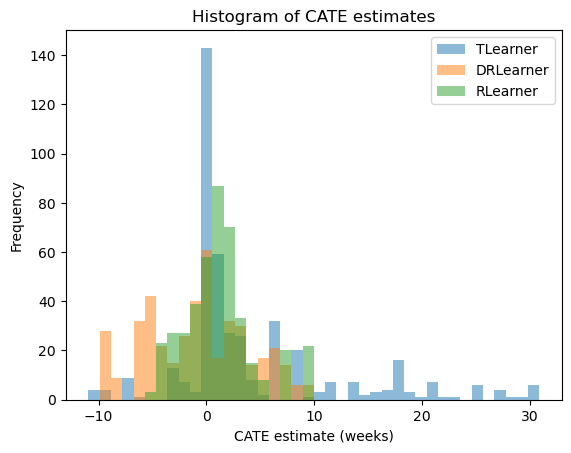

In [5]:
from lightgbm import LGBMClassifier, LGBMRegressor
from metalearners import TLearner, DRLearner, RLearner
from metalearners.utils import simplify_output
import matplotlib.pyplot as plt

tlearner = TLearner(False, 2, SurvivalModel, nuisance_model_params={"n_estimators": 5})
tlearner.fit(X, y, w)
cate_estimates_tlearner = simplify_output(tlearner.predict(X, True))

drlearner = DRLearner(
    False,
    2,
    nuisance_model_factory=SurvivalModel,
    propensity_model_factory=LGBMClassifier,
    treatment_model_factory=LGBMRegressor,
    nuisance_model_params={"n_estimators": 5},
    propensity_model_params={"verbose": -1, "n_estimators": 5},
    treatment_model_params={"verbose": -1, "n_estimators": 5},
)
drlearner.fit(
    X,
    y,
    w,
    fit_params={
        "treatment": {"treatment_model": {"sample_weight": treatment_sample_weight}}
    },
)
cate_estimates_drlearner = simplify_output(drlearner.predict(X, True))

rlearner = RLearner(
    False,
    2,
    nuisance_model_factory=SurvivalModel,
    propensity_model_factory=LGBMClassifier,
    treatment_model_factory=LGBMRegressor,
    nuisance_model_params={"n_estimators": 5},
    propensity_model_params={"verbose": -1, "n_estimators": 5},
    treatment_model_params={"verbose": -1, "n_estimators": 5},
)
rlearner.fit(X, y, w)
cate_estimates_rlearner = simplify_output(rlearner.predict(X, True))

bins = np.histogram(
    np.hstack(
        (cate_estimates_tlearner, cate_estimates_drlearner, cate_estimates_rlearner)
    ),
    bins=40,
)[1]

plt.hist(cate_estimates_tlearner, bins=list(bins), alpha=0.5, label="TLearner")
plt.hist(cate_estimates_drlearner, bins=list(bins), alpha=0.5, label="DRLearner")
plt.hist(cate_estimates_rlearner, bins=list(bins), alpha=0.5, label="RLearner")
plt.legend()
plt.xlabel("CATE estimate (weeks)")
plt.ylabel("Frequency")
plt.title("Histogram of CATE estimates")
plt.show()